In [ ]:
#@title Insatlling PyTorch

!pip install torch
!pip install torchvision

In [1]:
#@title Import dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
#@title Define hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = [100] # number of neurons at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-3 # size of step

In [3]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)
test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
print("Size of the train dataset:",tuple(train_data.data.shape))
print("Size of the test dataset:",tuple(test_data.data.shape))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.5kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 240kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Size of the train dataset: (60000, 28, 28)
Size of the test dataset: (10000, 28, 28)


In [4]:
#@title Loading the data

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)
test_loder = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

Image size: torch.Size([28, 28])
Label of this image: 3


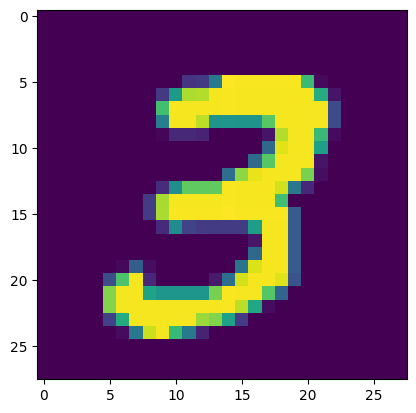

In [20]:
#@title Show the data

images = train_data.data
labels = train_data.targets
image = images[7]
label = labels[7]
print("Image size:",tuple(image.shape))
print("Label of this image:",label.numpy())
plt.imshow(image.numpy().squeeze())

In [6]:
#@title Define model class

class FCNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FCNN, self).__init__()

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        layers = []

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ReLU())  # Using ReLU activation function

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [7]:
#@title Build the model

net = FCNN(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()

In [8]:
#@title Define loss-function & optimizer

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=lr)

In [9]:
#@title Training the model

losses = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = Variable(images.view(-1,28*28)).cuda()
    labels = Variable(labels).cuda()
    optimizer.zero_grad()
    outputs = net(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    if (i+1) % batch_size == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.data))
  losses.append(loss.data.cpu())

Epoch [1/20], Step [100/600], Loss: 0.3228
Epoch [1/20], Step [200/600], Loss: 0.3353
Epoch [1/20], Step [300/600], Loss: 0.4081
Epoch [1/20], Step [400/600], Loss: 0.2491
Epoch [1/20], Step [500/600], Loss: 0.1638
Epoch [1/20], Step [600/600], Loss: 0.2690
Epoch [2/20], Step [100/600], Loss: 0.1744
Epoch [2/20], Step [200/600], Loss: 0.2062
Epoch [2/20], Step [300/600], Loss: 0.2452
Epoch [2/20], Step [400/600], Loss: 0.2223
Epoch [2/20], Step [500/600], Loss: 0.1441
Epoch [2/20], Step [600/600], Loss: 0.1267
Epoch [3/20], Step [100/600], Loss: 0.1291
Epoch [3/20], Step [200/600], Loss: 0.1516
Epoch [3/20], Step [300/600], Loss: 0.0809
Epoch [3/20], Step [400/600], Loss: 0.1455
Epoch [3/20], Step [500/600], Loss: 0.1033
Epoch [3/20], Step [600/600], Loss: 0.1350
Epoch [4/20], Step [100/600], Loss: 0.1149
Epoch [4/20], Step [200/600], Loss: 0.1866
Epoch [4/20], Step [300/600], Loss: 0.1862
Epoch [4/20], Step [400/600], Loss: 0.0794
Epoch [4/20], Step [500/600], Loss: 0.0964
Epoch [4/20

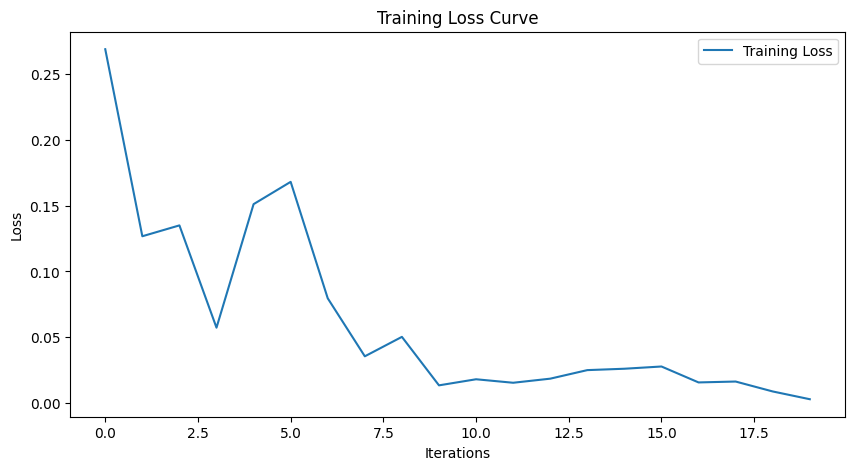

In [10]:
# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

In [12]:
#@title Save the model

torch.save(net.state_dict(), '/content/fcnn_1_100_100.pth')

In [13]:
#@title Evaluating the accuracy of the model

from google.colab import files
# files.download('fcnn_1_100.pth')
net = FCNN(input_size, hidden_size, num_classes)  # Instantiate your model class
net.load_state_dict(torch.load('/content/fcnn_1_100_100.pth'))
net.eval().cuda()  # Set the model to evaluation mode
correct = 0
total = 0
for images,labels in test_loder:
  images = Variable(images.view(-1,28*28)).cuda()
  labels = labels.cuda()
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)
print('Accuracy of the net: %.3f %%' %((100*correct)/(total+1)))

<ipython-input-13-b08e99589864>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('/content/fcnn_1_100_100.pth'))


Accuracy of the net: 97.820 %


Label of the image: 7
The prediction: [7]


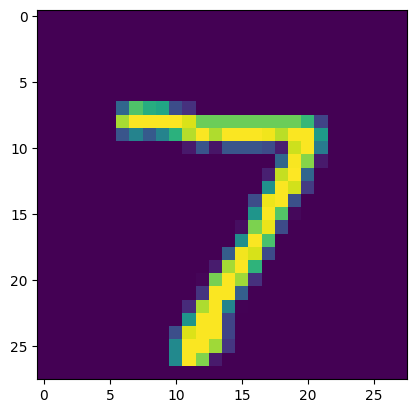

In [14]:
#@title Test some examples in MNIST (Correct prediction: obvious)

images = test_data.data
labels = test_data.targets
image = images[0].to(torch.float32)
label = labels[0]
plt.imshow(image.numpy().squeeze())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

Label of the image: 6
The prediction: [6]


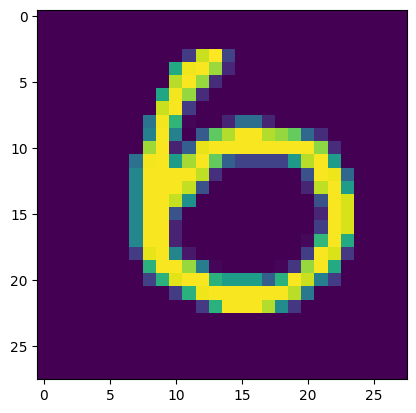

In [15]:
#@title Test some examples in MNIST (Correct prediction: 6 or 0?)

images = test_data.data
labels = test_data.targets
image = images[259].to(torch.float32)
label = labels[259]
plt.imshow(image.numpy().squeeze())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

Label of the image: 6
The prediction: [0]


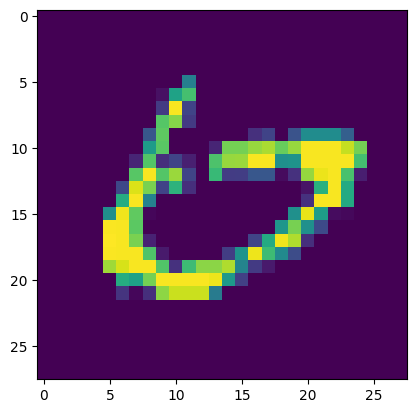

In [16]:
#@title Test some examples in MNIST (Wrong prediction: 6 or 0?)

images = test_data.data
labels = test_data.targets
image = images[445].to(torch.float32)
label = labels[445]
plt.imshow(image.numpy().squeeze())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

Label of the image: 5
The prediction: [6]


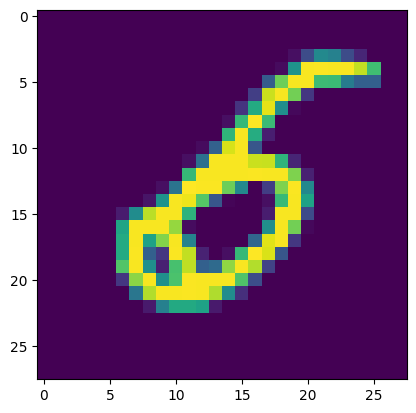

In [17]:
#@title Test some examples in MNIST (Wrong prediction)

images = test_data.data
labels = test_data.targets
image = images[9729].to(torch.float32)
label = labels[9729]
plt.imshow(image.numpy().squeeze())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

Label of the image: 8
The prediction: [8]


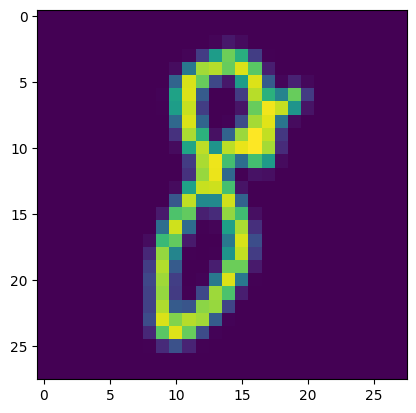

In [39]:
#@title Test real handwritten digits (Correct prediction)

from PIL import Image
import torchvision.transforms as transforms

# Load the JPG image using PIL
image_jpg = Image.open('/content/test8.jpg')
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
image = 1-transform(image_jpg).squeeze()
# print(image_tensor.shape)
plt.imshow(image.numpy())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",8)
print("The prediction:",prediction.numpy())

Label of the image: 1
The prediction: [1]


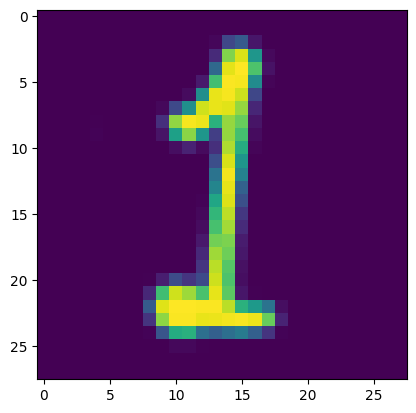

In [41]:
# Load the JPG image using PIL
image_jpg = Image.open('/content/test1.jpg')
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
image = 1-transform(image_jpg).squeeze()
# print(image_tensor.shape)
plt.imshow(image.numpy())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",1)
print("The prediction:",prediction.numpy())